# Cats and Dogs (Transfer Learning - ResNet50)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.model_selection import train_test_split

rows = 197
cols = 197

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import os, shutil
# print(os.listdir("../input"))

In [2]:
source_data_dir = "data/train"
try:
    os.mkdir("data/training_set/cats")
    os.mkdir("data/training_set/dogs")
    os.mkdir("data/validation_set/cats")
    os.mkdir("data/validation_set/dogs")
except:
    pass

In [3]:
if os.listdir("data/training_set/cats")=="":
    # If the folder contains no pictures start copying
    for file in ["cat.{}.jpg".format(i) for i in range (2000)]:
        shutil.copyfile(os.path.join(source_data_dir, file), os.path.join("data/training_set/cats", file))
    for file in ["dog.{}.jpg".format(i) for i in range (2000)]:
        shutil.copyfile(os.path.join(source_data_dir, file), os.path.join("data/training_set/dogs", file))
    for file in ["cat.{}.jpg".format(i) for i in range (2000, 2500)]:
        shutil.copyfile(os.path.join(source_data_dir, file), os.path.join("data/validation_set/cats", file))
    for file in ["dog.{}.jpg".format(i) for i in range (2000, 2500)]:
        shutil.copyfile(os.path.join(source_data_dir, file), os.path.join("data/validation_set/dogs", file))

# Data Pre-processing

In [4]:
from keras.applications import resnet50

Using TensorFlow backend.


In [5]:
model = resnet50.ResNet50()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [6]:
model = resnet50.ResNet50(include_top=False)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [7]:
from keras.applications.resnet50 import ResNet50
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.models import Model

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(197, 197, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(512, activation='relu')(x)

predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.train = False

In [8]:
from keras import optimizers
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.rmsprop(lr=1e-4),
              metrics=['acc'])

In [9]:
from keras.preprocessing.image import ImageDataGenerator

x_train_datagen = ImageDataGenerator(rescale=1./255)
x_val_datagen = ImageDataGenerator(rescale=1./255)

train_datagen = x_train_datagen.flow_from_directory("data/training_set",
                                                    target_size=(rows,cols),
                                                    batch_size=40,
                                                    class_mode='binary')
val_datagen = x_val_datagen.flow_from_directory("data/validation_set",
                                                target_size=(rows,cols),
                                                batch_size=40,
                                                class_mode='binary')



Found 4000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [10]:
epochs = 10

H = model.fit_generator(train_datagen,
                            steps_per_epoch=100,
                            epochs=epochs,
                            validation_data=val_datagen,
                            validation_steps=50)


Epoch 1/10
100/100 [==============================] - 90s 901ms/step - loss: 0.1150 - acc: 0.9532 - val_loss: 0.2391 - val_acc: 0.9650
Epoch 2/10
100/100 [==============================] - 85s 848ms/step - loss: 0.0239 - acc: 0.9920 - val_loss: 0.7850 - val_acc: 0.9240
Epoch 3/10
100/100 [==============================] - 85s 851ms/step - loss: 0.0145 - acc: 0.9960 - val_loss: 0.4954 - val_acc: 0.9540
Epoch 4/10
100/100 [==============================] - 85s 853ms/step - loss: 0.0185 - acc: 0.9965 - val_loss: 2.2392 - val_acc: 0.8270
Epoch 5/10
100/100 [==============================] - 86s 855ms/step - loss: 0.0172 - acc: 0.9950 - val_loss: 0.2132 - val_acc: 0.9820
Epoch 6/10
100/100 [==============================] - 86s 856ms/step - loss: 0.0129 - acc: 0.9975 - val_loss: 0.3102 - val_acc: 0.9640
Epoch 7/10
100/100 [==============================] - 86s 856ms/step - loss: 0.0133 - acc: 0.9965 - val_loss: 0.1884 - val_acc: 0.9780
Epoch 8/10
100/100 [==============================] - 8

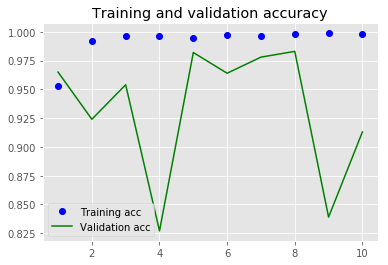

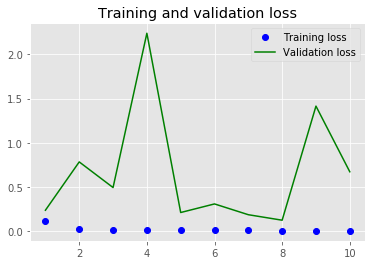

In [11]:
acc = H.history['acc']
val_acc = H.history['val_acc']
loss = H.history['loss']
val_loss = H.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

References:

1. [Anthony Tanbakuchi](http://tanbakuchi.com/posts/comparison-of-openv-interpolation-algorithms/ )







